### Imports

Required packages including those needed for `image_arrays.py` and `hdf_utils.py`.
- h5py
- numpy
- scipy
- matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

# local imports
from image_arrays import *
from hdf_utils import unpack_hdf
from plot_utils import clean_axes

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Load triggered stimulus data

In [3]:
data_path = "triggered_stimuli.h5"
# data_path = "fake_triggered_stimuli.h5"

with h5.File(data_path) as f:
    d = unpack_hdf(f)
    
print("Data Keys")
print("-------------")
for k in d.keys():
   print(k) 

Data Keys
-------------
avg_lead
col_x
cross_stacks
cross_xaxis
event_xaxis
grid_cols
grid_detrend_conv
grid_h
grid_recs
grid_rows
grid_w
lead
lead_conv
lead_xaxis
mean_lead
n_peaks_used
noise_frame_times
noise_freq
noise_hz
noise_xaxis
pos_to_roi
raw_noise
rec_height
rec_pts_per_cycle
rec_width
rec_x_offset
rec_y_offset
recs
recs_dt
recs_hz
recs_xaxis
roi_locs
row_y
stim_height
stim_width
trial_peak_lags
trial_peak_times
triggered_events
x_corner
y_corner


In [4]:
noise_frames, noise_cols, noise_rows = d["raw_noise"].shape
n_trials, n_pts, stack_rows, stack_cols = d["recs"].shape
n_kept_rois, _, lead_frames, _, _ = d["lead"].shape

### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

- `delta` sets the number of timesteps/frames that are scrolled per tick
- `roi_size` sets dynamic ROI size in pixels. This can either be scalar (e.g. `1`), or a tuple (e.g. `(1, 2)`) if you want a non-square ROI 

<IPython.core.display.Javascript object>


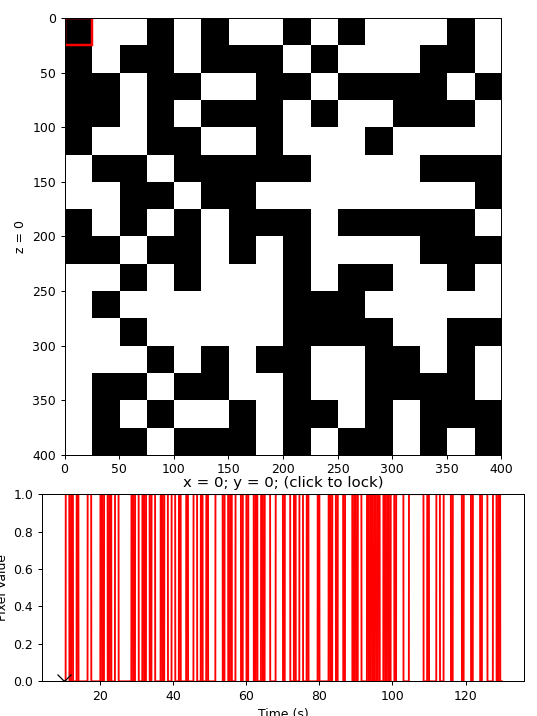

In [5]:
raw_noise_plot = StackExplorer(
    d["raw_noise"],
    zaxis=d["noise_xaxis"],
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    dims=(d["stim_width"], d["stim_height"]),
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.show()

### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. The currently selected trial will be highlighted in **red**. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

- `delta` sets the number of timesteps/frames that are scrolled per tick
- `roi_size` sets dynamic ROI size in pixels. This can either be scalar (e.g. `1`), or a tuple (e.g. `(1, 2)`) if you want a non-square ROI 

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


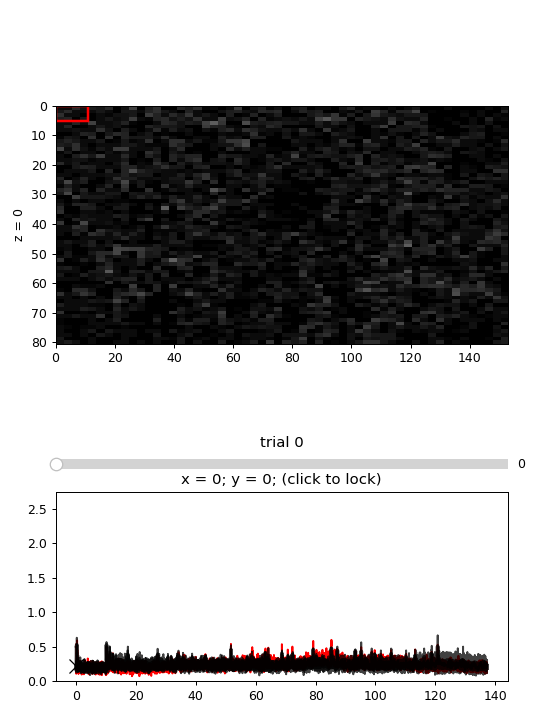

Recording shape: (8000, 64, 56)


In [6]:
stacks_plot = StackExplorer(
    d["recs"],
    zaxis=d["recs_xaxis"],
    delta=5,
    roi_sz=4,
    vmin=0,
    dims=(d["rec_width"], d["rec_height"]),
    figsize=(6, 8),
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", d["recs"][0].shape)
stacks_plot.fig.show()

### Explore Grid ROIs

<IPython.core.display.Javascript object>


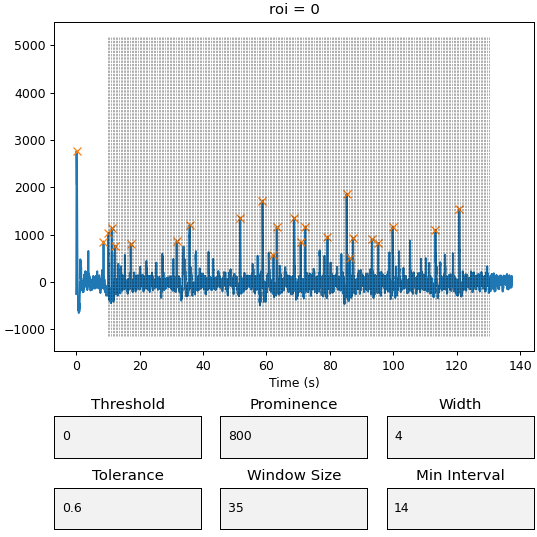

In [7]:
# display_recs = d["grid_recs"][0],
display_recs = d["grid_detrend_conv"][0]

peak_explorer = PeakExplorer(
    d["recs_xaxis"], 
    display_recs,
    prominence=800,
    width=4,
    tolerance=.6,
#     distance=1,
    distance=d["rec_pts_per_cycle"] // 2,
    wlen=35,
)

for t in d["noise_frame_times"]:
    peak_explorer.rec_ax.plot(
        [t, t], [display_recs.min(), display_recs.max()],
        c="black", alpha=0.5, linestyle="--", linewidth=0.5
    )

### Event triggered average of stimulus

This is the average stimulus that preceded events (with some time proceeding included) in each ROI. ROIs can be browsed via slider, and their physical position relative to the stimulus is shown by the **blue x**.

A 2Hz sine wave (one cycle) convolved version of the triggered stimulus has also been included in the data pack. To view that version instead, set `convolved_mode = True`.

<IPython.core.display.Javascript object>


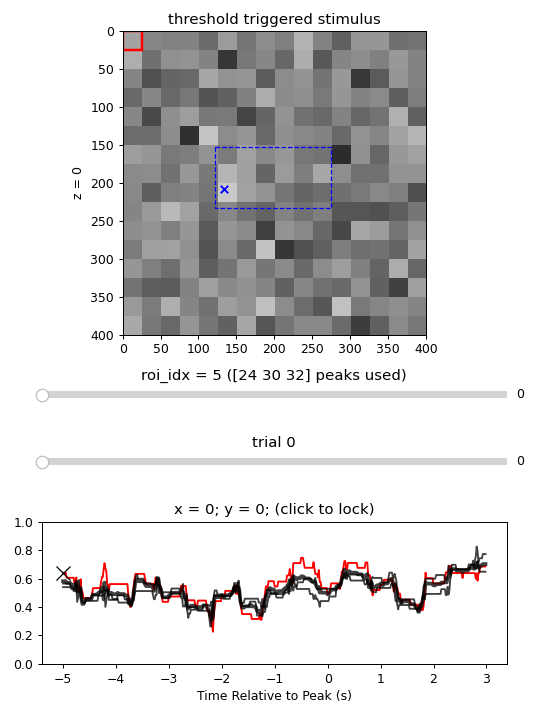

In [8]:
convolved_mode = False

if convolved_mode:
    lead = d["lead_conv"]
    vmin = -0.15
    vmax = 0.15
else:
    lead = d["lead"]
    vmin = 0.
    vmax = 1.

def roi_fmt_fun(i):
    return "roi_idx = %i (%s peaks used)" % (d["pos_to_roi"][i], str(d["n_peaks_used"][i]))

lead_stack_plot = StackExplorer(
    lead,
    zaxis=d["lead_xaxis"],
    delta=2,
    roi_sz=1,
    vmin=vmin,
    vmax=vmax,
    n_fmt_fun=roi_fmt_fun,
    dims=(d["stim_width"], d["stim_height"]),
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

def scan_field_rect():
    return Rectangle(
        (d["x_corner"] - .5, d["y_corner"] - .5),  # grid offset
        d["rec_width"], 
        d["rec_height"],  
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )

def update_roi_mark(mark):
    def f(i):
        x, y = d["roi_locs"][int(i)]
        x = (x + d["grid_w"] / 2) * d["col_x"] + d["x_corner"] 
        y = (y + d["grid_h"] / 2) * d["row_y"] + d["y_corner"]
        mark.set_offsets([[x, y]])
    return f

lead_stack_plot.ax[0].add_patch(scan_field_rect())
lead_roi_mark = lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(lead_roi_mark)(0)    
lead_stack_plot.n_slider.on_changed(update_roi_mark(lead_roi_mark))

lead_stack_plot.fig.show()

### Cross-ROI event triggered events

Each ROI is used to trigger averages of all the ROIs (including themselves) on a trial-by-trial basis. This can be interpreted as a simplistic view of the correlation between ROIs over space. Triggered events comparable in size to that in the reference ROI are highly likely to have events occuring in unison.

<IPython.core.display.Javascript object>


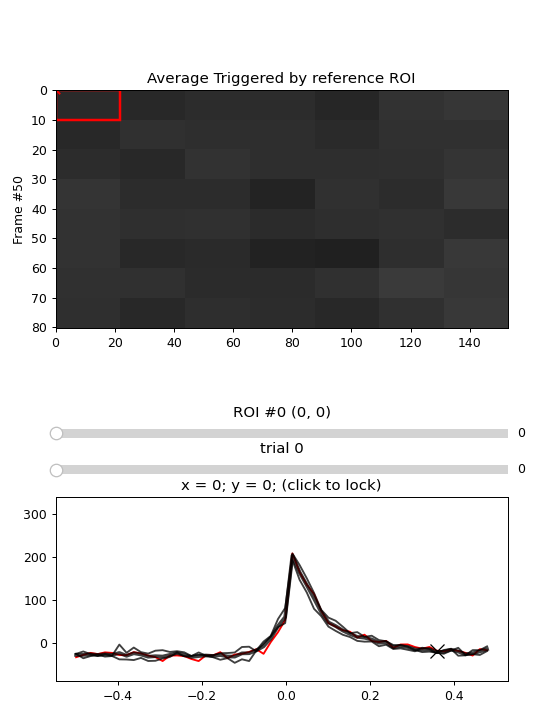

Text(0.5, 1.0, 'Average Triggered by reference ROI')

In [9]:
triggered_event_plot = StackExplorer(
    d["triggered_events"] - d["triggered_events"].mean(axis=2, keepdims=True),
    zaxis=d["event_xaxis"],
    delta=1,
    roi_sz=1,
    auto_roi_scale=False,
    z_fmt_fun=(lambda i: "Frame #%i" % i),
    n_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i // d["grid_rows"], i % d["grid_rows"]),
    dims=(d["rec_width"], d["rec_height"]),
    figsize=(6, 8)
)
triggered_event_plot.ax[2].set_xlabel("Time (s)")
triggered_event_plot.ax[2].set_ylabel("Response")
triggered_roi_mark = triggered_event_plot.ax[0].scatter([0], [0], marker="x", c="red")
triggered_event_plot.n_slider.on_changed(
    lambda v: triggered_roi_mark.set_offsets(
        [[(v // d["grid_rows"] + 0.5) + triggered_event_plot.x_frac,
          (v % d["grid_rows"] + 0.5) + triggered_event_plot.y_frac]]))

triggered_event_plot.ax[0].set_title("Average Triggered by reference ROI")

### Evolution of peak timing relative to noise frame updates over time

<IPython.core.display.Javascript object>


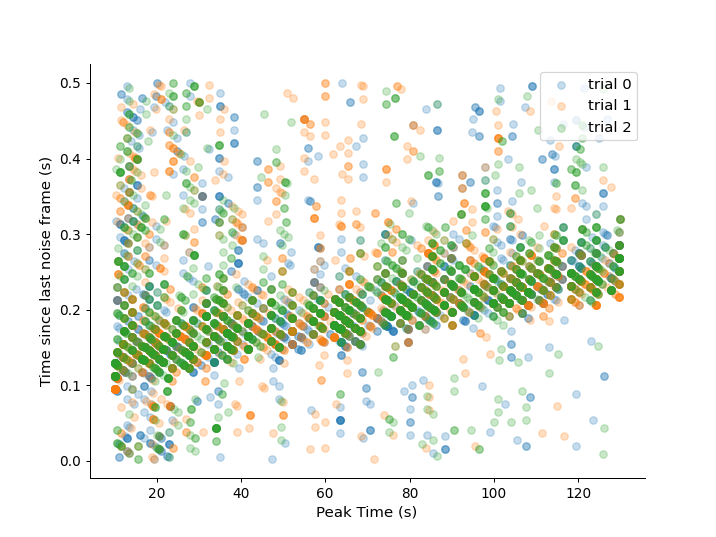

In [10]:
trial_lag_over_fig, trial_lag_over_ax = plt.subplots(1, figsize=(8, 6))
for i, (times, lags) in enumerate(
    zip(d["trial_peak_times"].values(), d["trial_peak_lags"].values())):
    trial_lag_over_ax.scatter(
        [t for roi in times.values() for t in roi],
        [t for roi in lags.values() for t in roi], 
        label="trial %i" % i,
        alpha=0.25,
    )
    
trial_lag_over_ax.set_ylabel("Time since last noise frame (s)", fontsize=12)
trial_lag_over_ax.set_xlabel("Peak Time (s)", fontsize=12)
trial_lag_over_ax.legend(fontsize=12, loc="upper right")
clean_axes(trial_lag_over_ax)

<IPython.core.display.Javascript object>


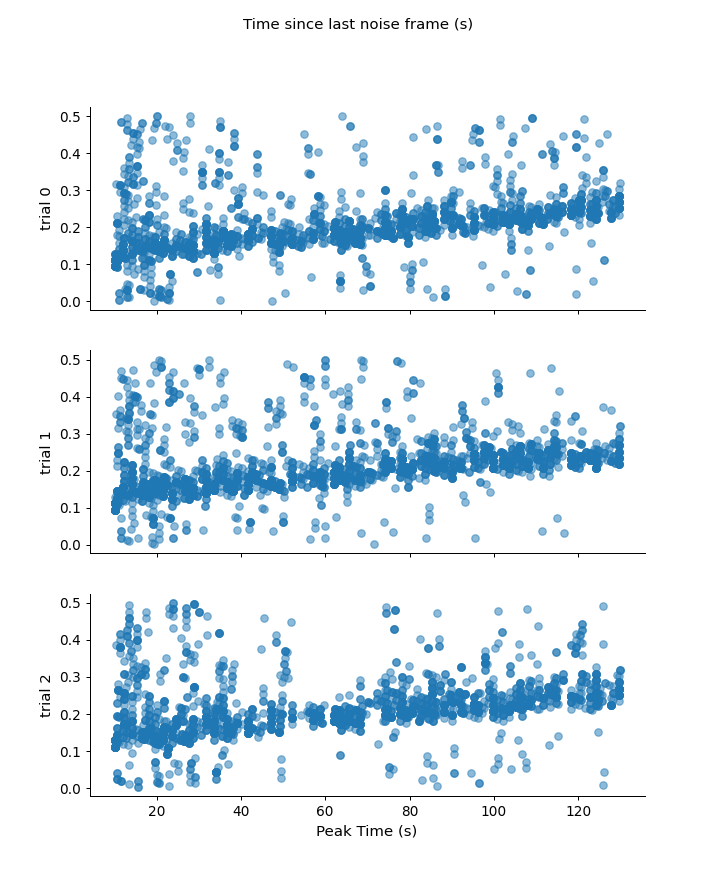

In [11]:
trial_lag_fig, trial_lag_ax = plt.subplots(3, sharex=True, sharey=True, figsize=(8, 10))
for i, (ax, times, lags) in enumerate(
    zip(trial_lag_ax, d["trial_peak_times"].values(), d["trial_peak_lags"].values())):
    ax.scatter(
        [t for roi in times.values() for t in roi],
        [t for roi in lags.values() for t in roi],
        alpha=0.5
    )
    ax.set_ylabel("trial %i" % i, fontsize=12)
    
    
trial_lag_fig.suptitle("Time since last noise frame (s)", fontsize=12)
trial_lag_ax[-1].set_xlabel("Peak Time (s)", fontsize=12)
clean_axes(trial_lag_ax)

### Rough "receptive field" map via response vs baseline subtraction
Set baseline and response windows in terms of `lead_xaxis`. Subtractions for all trials, as well as averages will be calculated and displayed in an interactive plot. Use mouse scroll to cycle between ROIs.

<IPython.core.display.Javascript object>


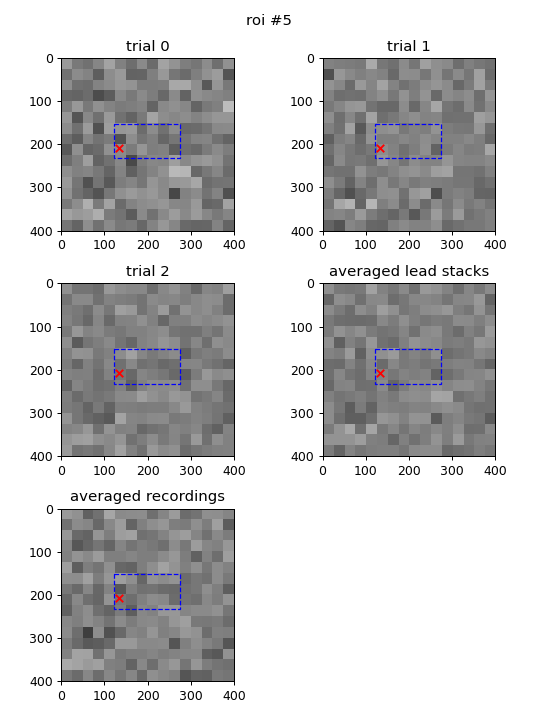

In [12]:
bsln_t0 = -1.5
bsln_t1 = -0.5
resp_t0 = -0.5
resp_t1 = 0.

bsln_mask = (d["lead_xaxis"] >= bsln_t0) * (d["lead_xaxis"] <= bsln_t1)
resp_mask = (d["lead_xaxis"] >= resp_t0) * (d["lead_xaxis"] <= resp_t1)
bsln = np.mean(d["lead"][:, :, bsln_mask], axis=2)
resp = np.mean(d["lead"][:, :, resp_mask], axis=2)

sub = resp - bsln
vmin = np.min(sub)
vmax = np.max(sub)

mean_lead_bsln = np.mean(d["mean_lead"][:, bsln_mask], axis=1)
mean_lead_resp = np.mean(d["mean_lead"][:, resp_mask], axis=1)
mean_lead_sub = mean_lead_resp - mean_lead_bsln

avg_lead_bsln = np.mean(d["avg_lead"][:, bsln_mask], axis=1)
avg_lead_resp = np.mean(d["avg_lead"][:, resp_mask], axis=1)
avg_lead_sub = avg_lead_resp - avg_lead_bsln

n_trials = sub.shape[1]
def title_fun(i):
    if i < n_trials:
        return "trial %i" % i
    elif i == n_trials:
        return "averaged lead stacks"
    elif i == n_trials + 1:
        return "averaged recordings"

sub_field_plotter = MultiStackPlotter(
    np.concatenate(
        [sub, np.expand_dims(mean_lead_sub, 1), np.expand_dims(avg_lead_sub, 1)],
        axis=1,
    ).transpose(1, 0, 2, 3),
    vmin=-.5,
    vmax=.5,
    cmap="gray",
    title_fmt_fun=title_fun,
    idx_fmt_fun=lambda i: "roi #%i" % d["pos_to_roi"][i],
    dims=(d["stim_width"], d["stim_height"]),
    figsize=(6, 8)
)

sub_field_updaters = []
for row in sub_field_plotter.ax:
    for ax in row:
        ax.add_patch(scan_field_rect())
        m = ax.scatter([0], [0], marker="x", c="red")
        sub_field_updaters.append(update_roi_mark(m))
        sub_field_updaters[-1](0)    
        
def sub_field_updater(_event):
    for u in sub_field_updaters:
        u(sub_field_plotter.idx)
        
sub_field_plotter.fig.canvas.mpl_connect("scroll_event", sub_field_updater)

sub_field_plotter.fig.tight_layout()

### Comparison of pre-event and post-event triggered contrast variance

This should give an idea of whether there is a real pattern emerging in the triggered stimulus responsible to driving the iGluSnfr responses. If the variance following `t = 0` is similar to the variance before, it suggests that the fluctuations are likely to be random. With enough averaging, the period following events should be more flat, since they could not have driven the preceding event, and should thus be averaged out.

<IPython.core.display.Javascript object>


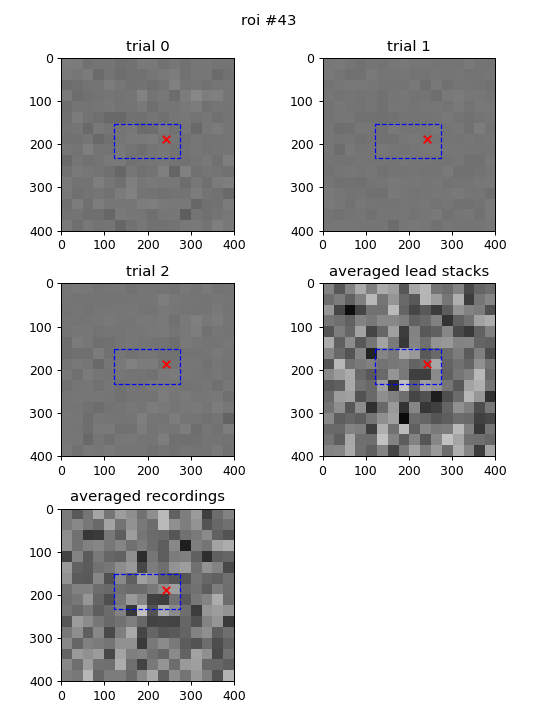

In [13]:
pre_t0 = -2
pre_t1 = 0
post_t0 = 1
post_t1 = 3.

pre_mask = (d["lead_xaxis"] >= pre_t0) * (d["lead_xaxis"] <= pre_t1)
post_mask = (d["lead_xaxis"] >= post_t0) * (d["lead_xaxis"] <= post_t1)

before_var = np.var(d["lead"][:, :, pre_mask], axis=2)
after_var = np.var(d["lead"][:, :, post_mask], axis=2)
var_diff = before_var - after_var

mean_before_var = np.mean(d["mean_lead"][:, pre_mask], axis=1, keepdims=True)
mean_after_var = np.mean(d["mean_lead"][:, post_mask], axis=1, keepdims=True)
mean_var_diff = mean_before_var - mean_after_var

avg_before_var = np.mean(d["avg_lead"][:, pre_mask], axis=1, keepdims=True)
avg_after_var = np.mean(d["avg_lead"][:, post_mask], axis=1, keepdims=True)
avg_var_diff = avg_before_var - avg_after_var

vmin = np.min(avg_var_diff)
vmax = np.max(avg_var_diff)

var_diff_plotter = MultiStackPlotter(
    np.concatenate(
        [var_diff, mean_var_diff, avg_var_diff],
        axis=1,
    ).transpose(1, 0, 2, 3),
    vmin=vmin,
    vmax=vmax,
    cmap="gray",
    title_fmt_fun=title_fun,
    idx_fmt_fun=lambda i: "roi #%i" % d["pos_to_roi"][i],
    dims=(d["stim_width"], d["stim_height"]),
    figsize=(6, 8)
)

var_diff_updaters = []
for row in var_diff_plotter.ax:
    for ax in row:
        ax.add_patch(scan_field_rect())
        m = ax.scatter([0], [0], marker="x", c="red")
        var_diff_updaters.append(update_roi_mark(m))
        var_diff_updaters[-1](0)    
        
def var_diff_updater(_event):
    for u in var_diff_updaters:
        u(var_diff_plotter.idx)
        
var_diff_plotter.fig.canvas.mpl_connect("scroll_event", var_diff_updater)
var_diff_plotter.fig.tight_layout()

In [14]:
print("Triggered Stimulus Contrast Variance (whole stimulus, all ROIs):")
print("  pre variance (%.3fs -> %.3fs) = %.5f" % (pre_t0, pre_t1, avg_before_var.mean()))
print("  post variance (%.3fs -> %.3fs) = %.5f" % (post_t0, post_t1, avg_after_var.mean()))
print("  post - pre = %.5f" % avg_var_diff.mean())

Triggered Stimulus Contrast Variance (whole stimulus, all ROIs):
  pre variance (-2.000s -> 0.000s) = 0.50000
  post variance (1.000s -> 3.000s) = 0.50000
  post - pre = 0.00000


### Checking whether there is any pattern associated with gross centre and surround regions of the noise stimulation
Since the scan region is much smaller than the stimulus, we might expect the area in the centre directly above or neighbouring the recorded terminals may have a bias to positive centre signals. Depending on the size of the receptive fields and their offset from the terminals however, this might not necessarily be the case.

Set the centre field rectangle by spatial indices corresponding to the `raw_noise` stack, with `centre_{t,b,l,r}` ( top / bottom / left / right ) variables.

centre mask:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
surround mask:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

<IPython.core.display.Javascript object>


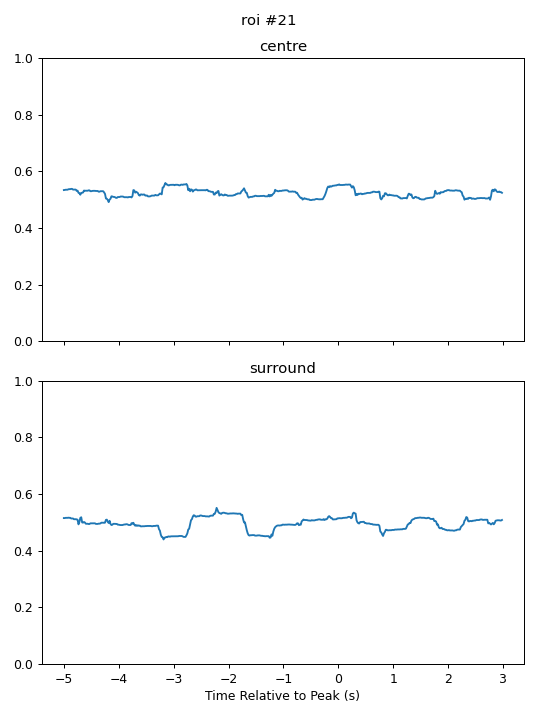

In [15]:
centre_t = 7
centre_b = 9
centre_l = 5
centre_r = 11
centre_mask = np.zeros((noise_cols, noise_rows), dtype=int)
centre_mask[centre_t:centre_b, centre_l:centre_r] = 1
surround_mask = np.zeros((noise_cols, noise_rows), dtype=int)
surround_mask[centre_t-1:centre_b+1, centre_l:centre_r] = 1
surround_mask -= centre_mask
print("centre mask:\n", centre_mask)
print("surround mask:\n", surround_mask)

lead_stacks_flat = d["lead"].reshape(d["lead"].shape[0], n_trials, lead_frames, -1)
centre_beams = np.mean(
    lead_stacks_flat[:, :, :, centre_mask.reshape(-1).astype(bool)], axis=3)
surround_beams = np.mean(
    lead_stacks_flat[:, :, :, surround_mask.reshape(-1).astype(bool)], axis=3)

centre_surround_plotter = MultiWavePlotter(
    [np.mean(centre_beams, axis=1, keepdims=True), np.mean(surround_beams, axis=1, keepdims=True)],
    xaxis=d["lead_xaxis"],
    ymin=0,
    ymax=1,
    title_fmt_fun=lambda i: "centre" if not i else "surround",
    idx_fmt_fun=lambda i: "roi #%i" % d["pos_to_roi"][i],
    figsize=(6, 8),
    sharex=True,
)
centre_surround_plotter.ax[1].set_xlabel("Time Relative to Peak (s)")
centre_surround_plotter.fig.tight_layout()

### Cross Correlation of transformed (convolved and detrended) ROIs and Stimulus

<IPython.core.display.Javascript object>


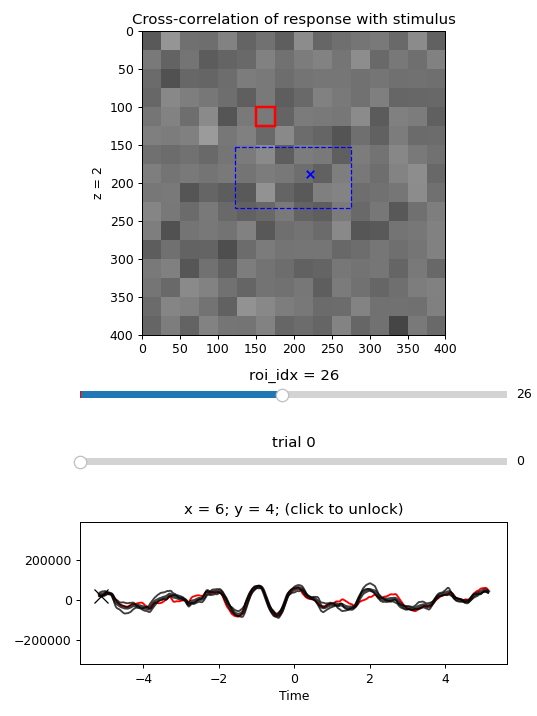

In [16]:
cross_stack_plot = StackExplorer(
    d["cross_stacks"],
#     np.expand_dims(d["avg_cross_stacks"], 1),
    zaxis=d["cross_xaxis"],
    delta=1,
    roi_sz=1,
    n_fmt_fun=lambda i: "roi_idx = %i" % i,
    dims=(d["stim_width"], d["stim_height"]),
    figsize=(6, 8)
)
cross_stack_plot.stack_ax.set_title("Cross-correlation of response with stimulus")
cross_stack_plot.beam_ax.set_xlabel("Time")
cross_stack_plot.fig.tight_layout()

cross_stack_plot.ax[0].add_patch(scan_field_rect())
cross_roi_mark = cross_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(cross_roi_mark)(0)    
if cross_stack_plot.n_sz > 1:
    cross_stack_plot.n_slider.on_changed(update_roi_mark(cross_roi_mark))
cross_stack_plot.fig.show()